# Quick Start on Bayesian Kernel Regression Model

In [1]:
import orbit
from orbit.template.ktr import KTRModel
from orbit.forecaster import SVIForecaster
from orbit.estimators.pyro_estimator import PyroEstimatorVI

In [2]:
orbit.__version__

'1.0.16dev'

In [3]:
%load_ext autoreload
%autoreload 2

## Modeling Daily Series

In [4]:
from orbit.utils.dataset import load_electricity_demand

In [5]:
elect_df = load_electricity_demand()
elect_df.head(5)

,date,electricity
0,2000-01-01,12551.500000
1,2000-01-02,13377.041667
2,2000-01-03,15300.625000
3,2000-01-04,15582.750000
4,2000-01-05,15691.750000


In [6]:
ktr_template = KTRModel(

    level_knot_scale=0.1,
#     regressor_col=None,
#     regressor_init_knot_loc=[0] * len(regressor_col),
#     regressor_init_knot_scale=[1.0] * len(regressor_col),
#     regressor_knot_scale=[0.5] * len(regressor_col),
#     regression_segments=5,

    span_coefficients=0.1,
    rho_coefficients=0.05,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,

    flat_multiplier=True,
    min_residuals_sd=1.0
)
ktr = SVIForecaster(
    response_col='electricity',
    date_col='date',
    model=ktr_template,
    verbose=True,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
)

In [7]:
ktr.fit(df=elect_df)  

INFO:root:Guessed max_plate_nesting = 1


Initial log joint probability = -28505.9
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -28161.4    0.00892734       6.58286      0.0736      0.0736       26   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -28160.6   0.000962006       6.52598      0.6799      0.6799       56   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55      -28160.6   1.36066e-05       6.56543      0.3493      0.3493       81   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
step    0 loss = 31215, scale = 0.097368
step  100 loss = 31212, scale = 0.33822
step  200 loss = 31212, scale = 0.33075
step  300 loss = 31212, scale = 0.35652
step  400 loss = 31211, scale = 0.37638
step  500 loss = 31212, scale = 0.33542
step  600 loss = 31212, scale = 0.34642
step  700 loss = 31211, scale = 0.3

In [11]:
# visualize level and level knots
ktr.get_level_knots()

,date,lev_knot
0,2000-01-03,17427.161987
1,2001-01-02,17427.200608
2,2002-01-02,17427.173602
3,2003-01-02,17427.152972
4,2004-01-02,17427.180580
5,2005-01-01,17427.152279
6,2006-01-01,17427.151638
7,2007-01-01,17427.168211
8,2008-01-01,17427.169198
9,2008-12-31,17427.183719


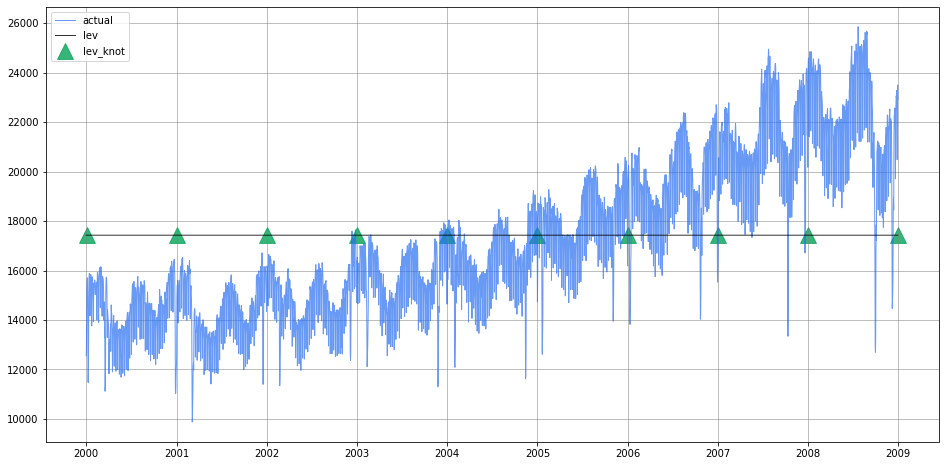

<AxesSubplot:>

In [12]:
ktr.plot_lev_knots()

In [9]:
ktr._model._level_knot_dates

DatetimeIndex(['2000-01-03', '2001-01-02', '2002-01-02', '2003-01-02',
               '2004-01-02', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2008-12-31'],
              dtype='datetime64[ns]', freq=None)

# A Simulation Study for Time-varying coefficients

In [1]:
import math
from math import pi
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist

from orbit.estimators.pyro_estimator import PyroEstimatorVI
from orbit.estimators.stan_estimator import StanEstimatorMAP
from orbit.diagnostics.metrics import smape
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

# Data Simulation Modules

In [2]:
def sim_data_seasonal(n, RS):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)
    # make the time varing coefs  
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': 1.01 + np.sin(2*pi*tau),
        'beta3': 1.01 + np.sin(4*pi*(tau-1/8)),
#         'x1': stats.chi2.rvs(4, size=n),
#         'x2': stats.t.rvs(2, size=n),
#         'x3': stats.t.rvs(2, size=n),
        'x1': np.random.normal(0, 10, size=n),
        'x2': np.random.normal(0, 10, size=n),
        'x3': np.random.normal(0, 10, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })
    
    # add error to the data 
    #err_cov = np.exp(-cdist(data.tau.values.reshape(n, -1), data.tau.values.reshape(n, -1), 'euclid')/10)
    #L = np.linalg.cholesky(err_cov).T
    #data['error2'] = L.dot(stats.chi2.rvs(100, size=n))
    
    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    #data['y2'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error2
    #data['y3'] = data.trend + data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

def sim_data_rw(n, RS, p=3):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))], 
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 10, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta, columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)
        
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))

    return data

In [3]:
seas_data = sim_data_seasonal(n=1000, RS=8888)
seas_data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.001,2018-01-01,0.002,1.016283,0.010079,-4.112205,6.235252,8.318071,1.000000,-0.772024,5.640371
1,0.002,2018-01-02,0.004,1.022566,0.010316,-0.499279,-14.816010,3.641032,1.075149,1.243571,-13.871215
2,0.003,2018-01-03,0.006,1.028848,0.010711,1.826034,-2.897783,-17.144133,1.278494,-0.352154,-3.506200
3,0.004,2018-01-04,0.008,1.035130,0.011263,24.874740,5.439502,6.055187,1.104741,-0.571943,5.325848
4,0.005,2018-01-05,0.010,1.041411,0.011973,1.734577,-16.383980,9.075009,1.059079,-0.218024,-17.154473
5,0.006,2018-01-06,0.012,1.047690,0.012841,-11.059695,12.494699,2.577940,1.088198,0.541397,13.532358
6,0.007,2018-01-07,0.014,1.053968,0.013866,-6.065916,4.606459,-9.182241,1.153368,0.474600,5.117413
7,0.008,2018-01-08,0.016,1.060244,0.015049,0.945238,3.450288,13.376691,1.244678,2.122431,5.997009
8,0.009,2018-01-09,0.018,1.066519,0.016389,11.628231,11.262647,16.722551,1.167512,0.439053,12.934243
9,0.010,2018-01-10,0.020,1.072791,0.017885,2.740874,2.271040,-17.405263,1.352738,0.496264,2.676133


In [4]:
rw_data = sim_data_rw(n=300, RS=8888, p=3)
rw_data.head(10)

,x1,x2,x3,beta1,beta2,beta3,y,date
0,1.118687,12.579436,-18.705481,0.083833,0.118039,0.106882,4.238243,2018-01-01
1,0.251493,5.300673,8.974563,0.081579,0.116649,0.116075,6.762299,2018-01-02
2,-12.535904,2.134341,4.224095,0.083838,0.112736,0.121694,4.576347,2018-01-03
3,-6.830381,3.094571,-1.926185,0.067788,0.111347,0.126284,4.497561,2018-01-04
4,-3.370150,3.899625,-3.083105,0.086333,0.099882,0.138985,5.230371,2018-01-05
5,-3.364463,-4.186151,13.149254,0.076195,0.108590,0.142555,6.102766,2018-01-06
6,-3.663559,-14.795409,-1.731279,0.091534,0.099006,0.156208,3.284992,2018-01-07
7,7.205991,-5.623366,-11.806551,0.100954,0.099507,0.160083,2.529016,2018-01-08
8,-3.643661,3.799626,-1.398166,0.100640,0.087954,0.163894,4.908982,2018-01-09
9,9.222329,1.695171,-0.896493,0.098496,0.085971,0.172410,5.529784,2018-01-10


In following section, let's start with random walk type of simulation.

## Test on how knots and segements interact

In [82]:
from orbit.utils.knots import get_knot_idx_by_dist, get_knot_idx, get_knot_dates

In [60]:
knot_idx = get_knot_idx(num_of_obs=400, num_of_segments=10)
knot_idx

array([ -1,  39,  79, 119, 159, 199, 239, 279, 319, 359, 399])

In [61]:
knot_idx = get_knot_idx(num_of_obs=250, knot_distance=10)
knot_idx

array([ -1,   9,  19,  29,  39,  49,  59,  69,  79,  89,  99, 109, 119,
       129, 139, 149, 159, 169, 179, 189, 199, 209, 219, 229, 239, 249])

In [62]:
date_array = rw_data['date'].values
date_array.dtype

dtype('<M8[ns]')

In [63]:
date_array[:5]

array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000',
       '2018-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [64]:
knot_dates=['2018-01-01','2018-07-01','2018-09-09']
knot_dates = np.array(knot_dates, dtype='datetime64')
knot_dates[:5]

array(['2018-01-01', '2018-07-01', '2018-09-09'], dtype='datetime64[D]')

In [65]:
knot_idx = get_knot_idx(date_array=date_array, knot_dates=knot_dates)
knot_idx

array([  0, 181, 251])

In [66]:
infer_freq = pd.infer_freq(date_array)

In [79]:
knot_idx * np.timedelta64(1, infer_freq)  + date_array[0]

array(['2018-01-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-09-09T00:00:00.000000000'], dtype='datetime64[ns]')

In [83]:
get_knot_dates(date_array[0], knot_idx, infer_freq)

array(['2018-01-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-09-09T00:00:00.000000000'], dtype='datetime64[ns]')

## KTRLite

**KTRLite** is used to learn the trend.  We will use a default to do that.

In [84]:
from orbit.models import KTRLite

In [85]:
p = 3

In [89]:
# define independent and response variabel
regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]
response_col = 'y'

# run the model 
# run lite first 
ktr_lite = KTRLite(response_col=response_col,
                      date_col='date',
                      seed=2020,
                      estimator='stan-map')

ktr_lite.fit(df=rw_data)

level_knot_scale = ktr_lite._model.level_knot_scale
level_knot_dates = ktr_lite._model._level_knot_dates
# just because we know the intercept is zero
# level_knots_stan = np.squeeze(
#     ktr_lite.get_point_posteriors()['lev_knot'], 0)
level_knots_stan = np.array([0] * len(level_knot_dates))

Initial log joint probability = -679.991
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -508.305    0.00796006       6.52894       0.187       0.187       27   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      35      -508.218   0.000288255       5.66264   5.147e-05       0.001       90  LS failed, Hessian reset 
      39      -508.215   0.000311543       5.41597           1           1       95   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -508.214   4.68231e-07       6.24471     0.06139           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66      -508.214   3.90368e-07       6.00677           1           1      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [8]:
ktr_lite.get_point_posteriors()['lev_knot']

array([[5.10183113, 5.10179934, 5.10172334, 5.10172314, 5.10172331,
        5.10170916, 5.10170911, 5.21477709, 5.2147771 , 5.21477273]])

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [93]:
from orbit.template.ktrx import KTRXModel
from orbit.models import KTRX
from orbit.template.ktr import KTRModel

In [94]:
from orbit.forecaster import SVIForecaster

In [95]:
ktr_template = KTRModel(

    level_knot_scale=0.1,
    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[1.0] * len(regressor_col),
    regressor_knot_scale=[0.5] * len(regressor_col),
    regression_segments=5,

    span_coefficients=0.1,
    rho_coefficients=0.05,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,

    flat_multiplier=True,
    min_residuals_sd=1.0
)
ktr = SVIForecaster(
    response_col=response_col,
    date_col='date',
    model=ktr_template,
    verbose=True,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
)

In [96]:
ktr.fit(df=rw_data)  

INFO:root:Guessed max_plate_nesting = 1


Initial log joint probability = -1753.98
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -508.435     0.0198358       6.54518      0.5129      0.5129       29   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      32      -508.385    0.00109752       5.93291   0.0001911       0.001       79  LS failed, Hessian reset 
      39       -508.38   6.75609e-05       6.20416      0.3187      0.3187       90   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -508.379   3.77296e-06       5.89604           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68      -508.379    2.6496e-07       6.35696      0.1381      0.7526      133   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
step    0 loss = 815.03, s

In [18]:
# ktr = KTRX(
    
#     response_col=response_col,
#     date_col='date',
#     n_bootstrap_draws=-1,
#     estimator='pyro-svi',
    
#     level_knot_scale=level_knot_scale,
#     level_knot_dates=level_knot_dates,
#     level_knots=level_knots_stan,

#     regressor_col=regressor_col,
#     regressor_init_knot_loc=[0] * len(regressor_col),
#     regressor_init_knot_scale=[1.0] * len(regressor_col),
#     regressor_knot_scale=[0.5] * len(regressor_col),

#     span_coefficients=0.1,
#     rho_coefficients=0.05,
#     prediction_percentiles=[2.5, 97.5],
#     seed=2020,
#     num_steps=501,
#     num_sample=1000,
#     learning_rate=0.2,
#     learning_rate_total_decay=0.05,
#     verbose=True,
#     message=50,

#     # new setting we want to test
#     mvn=0,
#     flat_multiplier=True,
#     geometric_walk=False,
#     min_residuals_sd=1.0
# )

In [39]:
# %%time
# ktr.fit(df=rw_data)  

Initial log joint probability = -2509.51
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -508.388     0.0151679       6.48119      0.9793     0.09793       28   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -508.305    0.00612031       5.58729      0.5975           1       58   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40      -508.302    0.00146712       5.20724   0.0002626       0.001       94  LS failed, Hessian reset 
      59      -508.298   7.57975e-05        4.3271           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73      -508.298   5.03007e-07       4.74129      0.1018           1      158   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


ValueError: at site "rr_knot", invalid log_prob shape
  Expected [], actual [3]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions

In [42]:
ktr.extra_methods

['get_regression_coefs']

In [43]:
ktr._model._num_of_regressors

3

In [44]:
ktr._model.get_model_param_names()

['lev_knot', 'lev', 'yhat', 'obs_scale', 'coef_knot', 'coef_init_knot', 'coef']

In [49]:
ktr.get_posterior_samples()

{'lev_knot': array([[5.01419431, 5.09620549, 5.23622669, 5.26790073, 5.09482679,
         5.02260748, 5.05407869, 5.05682644, 5.15583557, 5.15932798],
        [5.1523982 , 5.16309743, 4.95956318, 5.1988801 , 4.96587882,
         5.02415611, 5.21355213, 5.13180847, 5.30463839, 5.1756956 ],
        [4.9452224 , 5.17026166, 5.22953021, 5.2310575 , 5.13795691,
         5.08964045, 5.31928101, 5.25696695, 5.24184112, 5.08807279],
        [5.10549721, 5.08815222, 4.9148479 , 5.07165778, 5.13257868,
         5.09887534, 5.08722606, 5.20422023, 5.22467093, 5.26111448],
        [4.91336407, 5.07224377, 5.38781033, 4.95356827, 5.05831815,
         4.93825716, 5.18019296, 5.17808784, 5.25429652, 5.34027439],
        [5.26404823, 5.06195759, 5.10481859, 5.13802161, 5.21375954,
         5.0236434 , 5.08371914, 5.25973197, 5.12430923, 5.01604426],
        [5.03999704, 5.08420794, 4.95081849, 4.96506002, 5.15651453,
         5.00964997, 5.19191339, 5.16435909, 5.15265772, 5.11810277],
        [4.9679

In [52]:
ktr._model._knots_tp_coefficients

array([0.50333333])

In [50]:
ktr._model._kernel_coefficients

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [46]:
idx = 3

In [47]:
# coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True, coefficient_method='empirical')
coef_mid  = ktr.get_regression_coefs()

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
# plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 3)

In [53]:
%debug

> /Users/edwinng/work/orbit-super/orbit/orbit/template/ktr.py(965)_get_regression_coefs_matrix()
    963             # if date_array not specified, dynamic coefficients in the training perior will be retrieved
    964             coef_knots = posteriors.get(RegressionSamplingParameters.COEFFICIENTS_KNOT.value)
--> 965             regressor_betas = np.matmul(coef_knots, self._kernel_coefficients.transpose((1, 0)))
    966             # back to batch x time step x regressor columns shape
    967             regressor_betas = regressor_betas.transpose((0, 2, 1))

ipdb> self._kernel_coefficients.transpose((1, 0)).shape
(1, 300)
ipdb> coef_knots
array([[0.22045524, 0.00260036, 0.21497029]])
ipdb> q


In [27]:
coef_mid

,date,x1,x2,x3
0,2018-01-01,0.142030,0.176172,0.125388
1,2018-01-02,0.141898,0.175481,0.125978
2,2018-01-03,0.141748,0.174695,0.126648
3,2018-01-04,0.141578,0.173802,0.127409
4,2018-01-05,0.141385,0.172789,0.128273
...,...,...,...,...
295,2018-10-23,0.382932,0.068329,0.146698
296,2018-10-24,0.383032,0.068792,0.145926
297,2018-10-25,0.383121,0.069201,0.145245
298,2018-10-26,0.383199,0.069561,0.144644


In [28]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

NameError: name 'ktrx_neutral' is not defined

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [ ]:
%%time
ktrx_pos = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
                    regressor_init_knot_scale=[1.0] * len(regressor_col),
                    regressor_knot_scale=[0.5] * len(regressor_col),
                    # this is the only change fromp previous setting
                    regressor_sign=['+'] * len(regressor_col),

                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=False,
                    min_residuals_sd=1.0)

ktrx_pos.fit(df=rw_data)                                  

In [ ]:
idx = 3

In [ ]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

In [ ]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Gemetric random walk structure with positive sign assumption and 

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [ ]:
%%time
ktrx_grw = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
    
                    # since we turn geometric_walk to true, this setting also need to be changed from previous
                    # i.e. scale parameter is interpreted differently
                    regressor_init_knot_scale=[1.0] * len(regressor_col),
                    regressor_knot_scale=[0.5] * len(regressor_col),
                    regressor_sign=['+'] * len(regressor_col),

                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=True,
                    min_residuals_sd=1.0)

ktrx_grw.fit(df=rw_data)                                  

In [ ]:
idx = 3

In [ ]:
coef_mid, coef_lower, coef_upper  = ktrx_grw.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

In [ ]:
_ = ktrx_grw.plot_regression_coefs(with_knot=True, figsize=(16, 8))

# Sine-cosine coefficients Simulation Study

## KTRLite

**KTRLite** is used to learn the trend.  We will use a default to do that.

In [ ]:
p = 3
# define independent and response variables
regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
response_col = 'y'


# run the model 
# run lite first 
ktr_lite = KTRLiteMAP(response_col=response_col,
                      date_col='date',
                      seed=2020,
                      estimator_type=StanEstimatorMAP)

ktr_lite.fit(df=seas_data)

level_knot_scale = ktr_lite.level_knot_scale
level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
level_knot_dates = ktr_lite._level_knot_dates
level_knots_stan = np.array([0] * len(level_knot_dates))

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [ ]:
%%time
ktrx_neutral = KTRXFull(response_col=response_col,
                        date_col='date',
                        level_knot_scale=level_knot_scale,
                        level_knot_dates=level_knot_dates,
                        level_knots=level_knots_stan,

                        regressor_col=regressor_col,
                        regressor_init_knot_loc=[0] * len(regressor_col),
                        regressor_init_knot_scale=[10.0] * len(regressor_col),
                        regressor_knot_scale=[2.0] * len(regressor_col),

                        span_coefficients=0.1,
                        rho_coefficients=0.05, 
                        prediction_percentiles=[2.5, 97.5],
                        seed=2020,
                        num_steps=501,
                        num_sample=1000,
                        learning_rate=0.2,
                        learning_rate_total_decay=0.05,
                        verbose=True,
                        message=50,
                        n_bootstrap_draws=-1,
                        estimator_type=PyroEstimatorVI, 
    
                        # new setting we want to test
                        mvn=0,
                        flat_multiplier=True,
                        geometric_walk=False,
                        min_residuals_sd=1.0)

ktrx_neutral.fit(df=seas_data)                                  

In [ ]:
idx = 3

In [ ]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

In [ ]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [ ]:
%%time
ktrx_pos = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
                    regressor_init_knot_scale=[10.0] * len(regressor_col),
                    regressor_knot_scale=[2.0] * len(regressor_col),
                    # this is the only change fromp previous setting
                    regressor_sign=['+'] * len(regressor_col),

                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=False,
                    min_residuals_sd=1.0)

ktrx_pos.fit(df=seas_data)                                  

In [ ]:
idx = 3

In [ ]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

In [ ]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Gemetric random walk structure with positive sign assumption and 

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [ ]:
%%time
ktrx_grw = KTRXFull(response_col=response_col,
                    date_col='date',
                    level_knot_scale=level_knot_scale,
                    level_knot_dates=level_knot_dates,
                    level_knots=level_knots_stan,

                    regressor_col=regressor_col,
                    regressor_init_knot_loc=[0] * len(regressor_col),
    
                    # since we turn geometric_walk to true, this setting also need to be changed from previous
                    # i.e. scale parameter is interpreted differently
                    regressor_init_knot_scale=[10.0] * len(regressor_col),
                    regressor_knot_scale=[0.2] * len(regressor_col),
                    regressor_sign=['+'] * len(regressor_col),
    
                    span_coefficients=0.1,
                    rho_coefficients=0.05, 
                    prediction_percentiles=[2.5, 97.5],
                    seed=2020,
                    num_steps=501,
                    num_sample=1000,
                    learning_rate=0.2,
                    learning_rate_total_decay=0.05,
                    verbose=True,
                    message=50,
                    n_bootstrap_draws=-1,
                    estimator_type=PyroEstimatorVI, 
    
                    # new setting we want to test
                    mvn=0,
                    flat_multiplier=True,
                    geometric_walk=True,
                    min_residuals_sd=1.0)

ktrx_grw.fit(df=seas_data)                                  

In [ ]:
idx = 3

In [ ]:
coef_mid, coef_lower, coef_upper  = ktrx_grw.get_regression_coefs(include_ci=True, coefficient_method='empirical')

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

In [ ]:
_ = ktrx_grw.plot_regression_coefs(with_knot=True, figsize=(16, 8))

In [ ]:
# def multiple_test(N, n, sim_type):
#     out = pd.DataFrame()
#     out['index'] = range(0, N)
#     # for hte model fit 
#     out['time_1'] = 0.0
#     out['time_2'] = 0.0
    
#     out['SSE_1'] = 0.0
#     out['SSE_2'] = 0.0
#     out['RMSE_1'] = 0.0
#     out['RMSE_2'] = 0.0
#     out['max_error_1'] = 0.0
#     out['max_error_2'] = 0.0
    
#     # for the true values 
#     out['SSE_beta1_1'] = 0.0
#     out['SSE_beta1_2'] = 0.0 
#     out['SSE_beta2_1'] = 0.0   
#     out['SSE_beta2_2'] = 0.0
#     out['SSE_beta3_1'] = 0.0
#     out['SSE_beta3_2'] = 0.0

    
#     for i in range(0, N):
#         # simulate the data 
#         if sim_type == 'sea':
#             data = sim_data_seasonal(n = n, RS = 1000+i)
       
#         if sim_type == 'rw':
#             data = sim_data_rw(n = n, RS = 1000+i, p=3)    
    
#         #print(data.head())
    
#         # define stuff 
#         regressor_col=['x1', 'x2', 'x3']
#         response_col = 'y'
#         # run the model 
#         # run lite first 
#         ktr_lite = KTRLiteMAP(
#             response_col=response_col,
#             date_col='date',
#             level_knot_scale=1,
#             seed=2000+i,
#             span_level= .1, 
#             estimator_type=StanEstimatorMAP,
#         )
#         ktr_lite.fit(df=data)
#         level_knot_scale = ktr_lite.level_knot_scale
#         level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
#         level_knot_dates = ktr_lite._level_knot_dates
#         level_knots_stan = np.array([0] * len(level_knot_dates))
        
#         ktrx1 = KTRXFull(
#             response_col=response_col,
#             date_col='date',

#             degree_of_freedom=30,
#             level_knot_scale=level_knot_scale,
#             level_knot_dates=level_knot_dates,
#             level_knots=level_knots_stan,

#             regressor_col=regressor_col,
#             regressor_knot_pooling_loc=[0] * len(regressor_col),
#             regressor_knot_pooling_scale=[1] * len(regressor_col),
# #             regressor_knot_scale=[1.0] * len(regressor_col),

#             span_coefficients=0.1,
#             rho_coefficients=0.1, 
#             prediction_percentiles=[2.5, 97.5],
#             seed=2000+i,
#             num_steps=1000,
#             num_sample=3000,
#             verbose=False,
#             message=100,
#             n_bootstrap_draws=-1,
#             estimator_type=PyroEstimatorVI,
#             mvn=1
#         )

#         ktrx2 = KTRXFull(
#             response_col=response_col,
#             date_col='date',

#             degree_of_freedom=30,
#             level_knot_scale=level_knot_scale,
#             level_knot_dates=level_knot_dates,
#             level_knots=level_knots_stan,

#             regressor_col=regressor_col,
#             regressor_knot_pooling_loc=[0] * len(regressor_col),
#             regressor_knot_pooling_scale=[1] * len(regressor_col),
#             regressor_knot_scale=[1.0] * len(regressor_col),

#             span_coefficients=0.1,
#             rho_coefficients=0.1, 
#             prediction_percentiles=[2.5, 97.5],
#             seed=2000+i,
#             num_steps=1000,
#             num_sample=3000,
#             verbose=False,
#             message=100,
#             n_bootstrap_draws=-1,
#             estimator_type=PyroEstimatorVI,
#         )
        
#         # fit the models and recod the times
#         start_time = time.time()
#         ktrx1.fit(df=data)
#         time_1 = time.time() - start_time
        
#         start_time = time.time()
#         ktrx2.fit(df=data)
#         time_2 = time.time() - start_time
        
#         # get the predictions 
#         predicted_df_1 = ktrx1.predict(df=data)
#         predicted_df_2 = ktrx2.predict(df=data)
            
#         # compare to observations  
#         SSE_1 = sum((predicted_df_1['prediction'] - data['y'])**2.0 )
#         SSE_2 = sum((predicted_df_2['prediction'] - data['y'])**2.0 )
        
#         max_misfit_1 = max(abs(predicted_df_1['prediction'] - data['y']) )
#         max_misfit_2 = max(abs(predicted_df_2['prediction'] - data['y']) )
    
#         out.at[i, 'time_1'] = time_1 
#         out.at[i, 'time_2'] = time_2 
    
#         out.at[i, 'SSE_1'] = SSE_1 
#         out.at[i, 'SSE_2'] = SSE_2 
        
#         out.at[i, 'RMSE_1'] = (SSE_1/n)**(0.5) 
#         out.at[i, 'RMSE_2'] = (SSE_2/n)**(0.5) 
        
        
#         out.at[i, 'max_error_1'] = max_misfit_1
#         out.at[i, 'max_error_2'] = max_misfit_2
        
#         #compare to true values 
#         coef_df_1= ktrx1.get_regression_coefs(
#         aggregate_method='median',
#         include_ci=False)
        
#         coef_df_2= ktrx2.get_regression_coefs(
#         aggregate_method='median',
#         include_ci=False)
        
#         SSE_beta1_1 = sum((coef_df_1['x1']-data['beta1'])**2.0)
#         SSE_beta2_1 = sum((coef_df_1['x2']-data['beta2'])**2.0)
#         SSE_beta3_1 = sum((coef_df_1['x3']-data['beta3'])**2.0)
#         SSE_beta1_2 = sum((coef_df_2['x1']-data['beta1'])**2.0)
#         SSE_beta2_2 = sum((coef_df_2['x2']-data['beta2'])**2.0)
#         SSE_beta3_2 = sum((coef_df_2['x3']-data['beta3'])**2.0)    
        
#         out.at[i,'SSE_beta1_1'] = SSE_beta1_1
#         out.at[i,'SSE_beta2_1'] = SSE_beta2_1
#         out.at[i,'SSE_beta3_1'] = SSE_beta3_1
#         out.at[i,'SSE_beta1_2'] = SSE_beta1_2
#         out.at[i,'SSE_beta2_2'] = SSE_beta2_2
#         out.at[i,'SSE_beta3_2'] = SSE_beta3_2
        
#     return out


In [ ]:
# out = multiple_test(N=2, n=300, sim_type='sea')

In [ ]:
# multiple_test(N=3, n=300, sim_type='rw')